## Batch image flattening with 2D plane using regression

#### Import packages and find all the *.nid files.

In [1]:
from NSFopen.read import read

import os
from os import listdir
from os.path import isfile, join

from glob import glob

import numpy as np

import collections

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

font = {'size': 12}
matplotlib.rc('font', **font)

files=glob('*.nid')

#### Plane fitting and median search functions

In [2]:
def fit2DPlane(matrix, xaxis, yaxis):
    m = len(xaxis)
    X1, Y1 = np.meshgrid(xaxis, yaxis)
    X = np.hstack(( np.reshape(X1, (m*m, 1)) , np.reshape(Y1, (m*m, 1)) ))
    X = np.hstack(( np.ones((m*m, 1)) , X ))
    YY = np.reshape(matrix, (m*m, 1))

    theta = np.dot(np.dot( np.linalg.pinv(np.dot(X.transpose(), X)), X.transpose()), YY)
    plane = np.reshape(np.dot(X, theta), (m, m))
    
    return plane

def findLimits(matrix, strength):
    array1D = matrix.flatten()
    mean = np.mean(array1D)
    stdev = np.std(array1D)
    armin = mean - strength/2*stdev
    armax = mean + strength/2*stdev
    return armin, armax

#### Define what to plot

In [3]:
signals = ['Topography','Z-Axis','Z-Axis Sensor'] # 'Amplitude', there could be more, i.e. 2nd lock-in signal, etc.
scan_direction = 'Forward' # 'Forward', 'Backward', '2nd Forward', '2nd Backward'
scan_to_plot = 'Image' # 'Image', 'Spec' or 'Sweep'

#### Build X, Y axes and read data

In [4]:
# We store the images and respective X and Y axes in ordered dictionaries
data_dict = collections.OrderedDict()
xaxis_dict = collections.OrderedDict()
yaxis_dict = collections.OrderedDict()
data_levelled = collections.OrderedDict()

# Read the data into the dictionaries, depending on the version of the file,
# there could be various identifiers, i.e. 'Topography' or 'Z-Axis'.
for filename in files:
    print(filename)
    afm = read(filename, verbose=False)
    available_channels = list(afm.data[scan_to_plot][scan_direction].index)
    
    signal_to_plot = [i for i in available_channels if i in signals][0]

    data = afm.data[scan_to_plot][scan_direction][signal_to_plot]*1e9

    param = afm.param
    xrange = param['X']['range'][0]
    yrange = param['Y']['range'][0]
    
    key = filename.split(".nid")[0]
    xaxis = np.linspace(0, xrange*1e6, len(data[0]))
    xaxis_dict[key] = xaxis
    
    yaxis = np.linspace(0, yrange*1e6, len(data[0]))
    yaxis_dict[key] = yaxis
    
    data_dict[key] = data

circles.nid
circles_holes.nid
grid.nid
squares_holes.nid


#### Apply plane fitting to all the data

In [5]:
for key in data_dict.keys():
    data = data_dict[key]
    xaxis = xaxis_dict[key]
    yaxis = yaxis_dict[key]
    
    plane = fit2DPlane(data, xaxis, yaxis)  
    data_levelled[key] = data-plane

#### Exclude rogue points

In [6]:
for key in data_levelled.keys():
    data = data_levelled[key]
    armin, armax = findLimits(data, 3) # 3 -means the range of the z-axis on the colorbar is 3 standard deviations.
    data_levelled[key] = np.clip(data, armin, armax)

#### Prepare the figure and plot

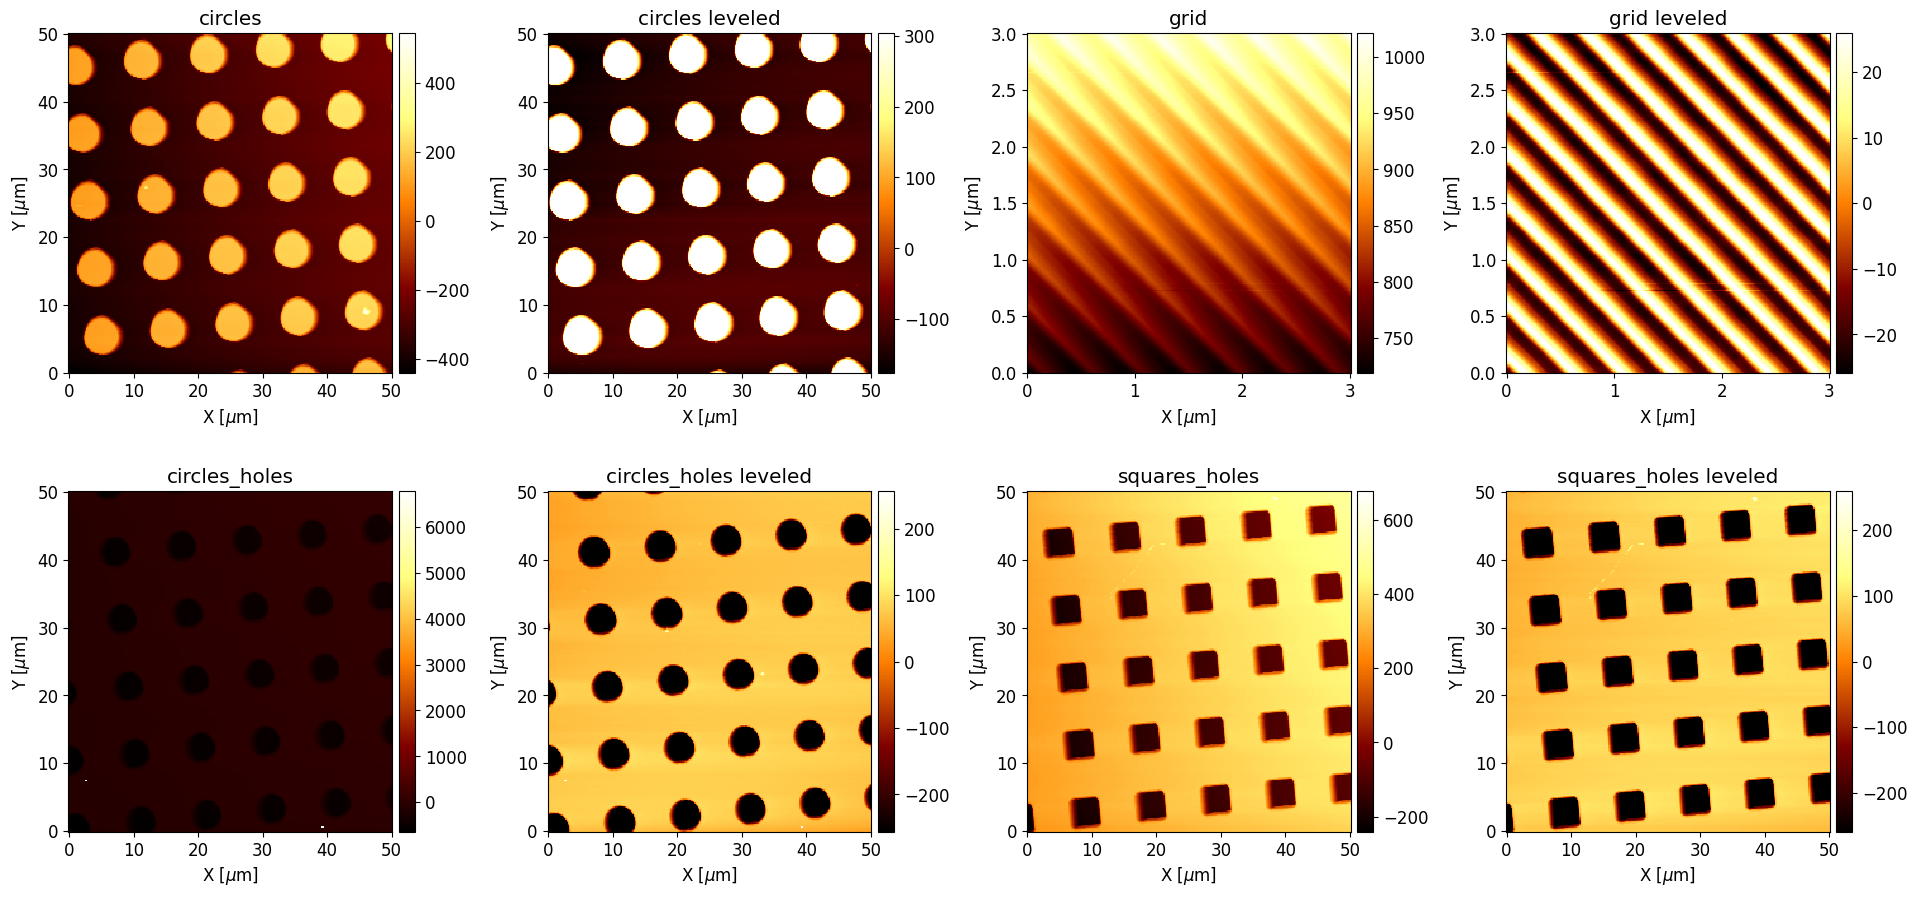

In [7]:
plot_columns = 4
plot_rows = int(np.ceil(len(data_dict)*2/plot_columns))

fig, ax = plt.subplots(plot_rows, plot_columns, figsize=(5*plot_columns,5*plot_rows))
fig.tight_layout(pad=5.0)

cmap = "afmhot" # colormap
xlbl = 'X [$\mu$m]'
ylbl = 'Y [$\mu$m]'
    
im=ax.copy()
for num, key in enumerate(data_dict):
    
    row = num%2
    col = int(np.floor(num/2)*2)

    im[row, col] = ax[row, col].pcolormesh(xaxis_dict[key], yaxis_dict[key], data_dict[key], cmap = cmap)
    im[row, col+1] = ax[row, col+1].pcolormesh(xaxis_dict[key], yaxis_dict[key], data_levelled[key], cmap = cmap)
    
    
    ax[row, col].set_title(key)
    ax[row, col+1].set_title(key + ' leveled')
    
    
for a,i in zip(ax.flatten(),im.flatten()):
    a.set(xlabel=xlbl, ylabel=ylbl)
    ax_divider = make_axes_locatable(a)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = plt.colorbar(i, cax=cax)

plt.show()